# Lab Report 1

### The goal of this lab is to understand the importance of Nyquist sampling and aliasing and how that can affect the voltage and power spectra obtained from applying a Fourier transformation on a waveform. Along the way, we will discuss common features of these spectra including spectral leakage and frequency resolution. Additionally, this lab will look into types of sideband mixers and their importance. 

In [226]:
#Import necessary packages for the notebook to run
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from scipy.signal import correlate
from scipy.stats import norm

In [426]:
#Import FIR Data for the first portion of analysis
# -------------------------------------------------
# Configuration
# -------------------------------------------------
data_dir = Path("./5.3/")

npz_files = [
    "FIRDataL1000000.0Hz.npz", "FIRDataL1250000.0Hz.npz", "FIRDataL1500000.0Hz.npz",
    "FIRDataL2000000.0Hz.npz", "FIRDataL2250000.0Hz.npz", "FIRDataL2500000.0Hz.npz",
    "FIRDataL2750000.0Hz.npz", "FIRDataL3000000.0Hz.npz", "FIRDataL3200000.0Hz.npz",
]

### When sampling a sine wave, the optimal frequency at which one can sample depends directly on the frequency of the waveform of interest. If one samples too high, unnecessary and even redundant information is collected. However, if the sampling frequency is slow enough, it is possible that it could miss an entire half period of the waveform and reconstruct a completely different frequency. Aliasing is result of using a sampling rate that is too slow and results in the folding over of a wave to create different data. The lowest value at which one can accurately sample at is what is referred to as the Nyquist frequency. The Nyquist criterion says that the frequency at which one samples should be at least twice the frequency of interest to ensure that aliasing is prevented. To get a better look at this, we will force aliasing by capturing a 300 kHz signal at varying sampling rates.

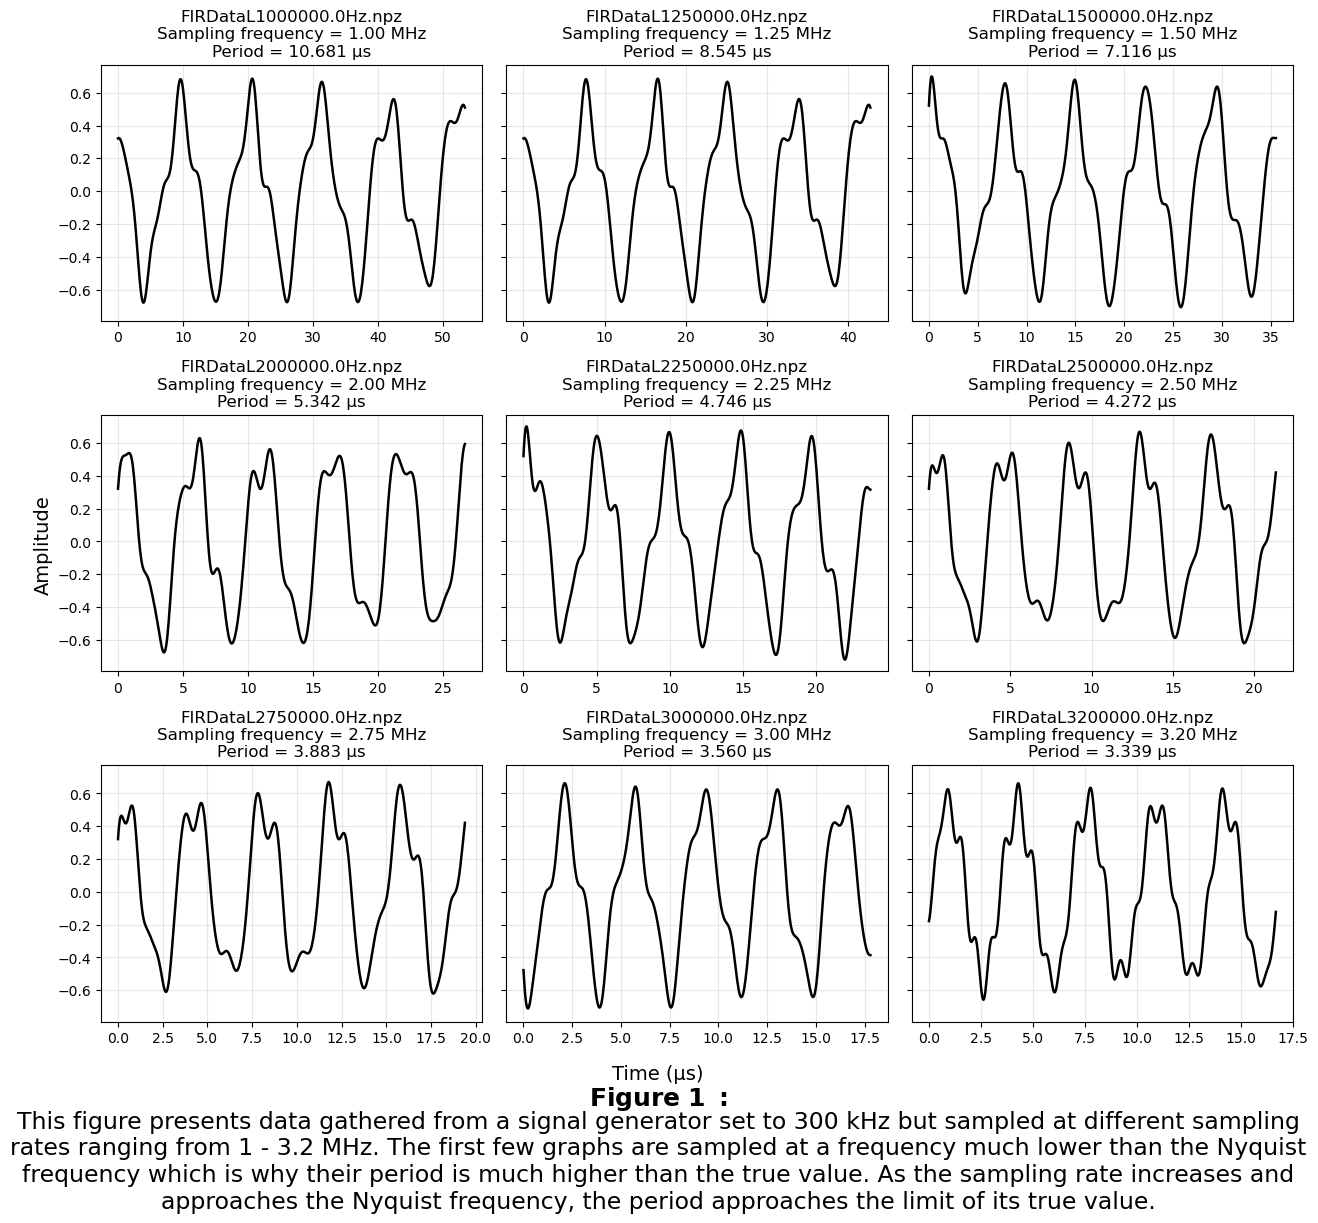

In [429]:
#Plotting varying sampling frequency to explore Nyquist criterion

N_CYCLES = 5
UPSAMPLE = 10   # interpolation factor

# -------------------------------------------------
# Extract sampling frequency from filename
# -------------------------------------------------
def freq_from_filename(fname):
    match = re.search(r"([\d\.]+)Hz", fname)
    if match is None:
        raise ValueError(f"Could not extract frequency from {fname}")
    return float(match.group(1))  # Hz

# -------------------------------------------------
# Compute period from data using zero crossings
# -------------------------------------------------
def compute_period(y, fs):
    y = y - np.mean(y)  # remove DC
    # Find zero crossings (sign change)
    zero_crossings = np.where(np.diff(np.sign(y)) > 0)[0]  # positive-going
    if len(zero_crossings) < 2:
        return None  # cannot compute period
    # Compute periods in samples
    periods_samples = np.diff(zero_crossings)
    # Convert to time in seconds
    periods_sec = periods_samples / fs
    return np.mean(periods_sec)

# -------------------------------------------------
# Create subplot grid
# -------------------------------------------------
fig, axes = plt.subplots(3, 3, figsize=(13, 11), sharey=True)
axes = axes.flatten()

# -------------------------------------------------
# Plot smoothed sine waves
# -------------------------------------------------
for ax, fname in zip(axes, npz_files):
    npz = np.load(data_dir / fname)

    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"])

    # Remove DC
    y -= np.mean(y)

    # ---- Estimate dominant frequency ----
    Y = np.fft.rfft(y)
    f = np.fft.rfftfreq(len(y), 1/fs)
    f0 = f[np.argmax(np.abs(Y))]

    # ---- FFT interpolation (zero padding) ----
    N = len(y)
    Y_pad = np.zeros(int(len(Y) * UPSAMPLE), dtype=complex)
    Y_pad[:len(Y)] = Y

    y_interp = np.fft.irfft(Y_pad)
    fs_interp = fs * UPSAMPLE

    # ---- Time axis ----
    t = np.arange(len(y_interp)) / fs_interp

    # ---- Select N cycles ----
    T = N_CYCLES / f0
    mask = t < T

    # Use filename frequency for label and window
    f_file = freq_from_filename(fname)

    # ---- Compute period from original data ----
    T_osc = compute_period(y, fs)  # seconds
    if T_osc is None:
        T_osc = 0
    T_plot = N_CYCLES * T_osc  # total time to plot N cycles

    mask = t < T_plot

    ax.plot(t[mask] * 1e6, y_interp[mask], lw=1.8, color = 'k')
    ax.set_title(f"{fname}\nSampling frequency = {f_file/1e6:.2f} MHz\nPeriod = {T_osc*1e6:.3f} µs", fontsize=12)
    ax.grid(True, alpha=0.3)

# -------------------------------------------------
# Labels & layout
# -------------------------------------------------
fig.supxlabel("Time (µs)", fontsize=14)
fig.supylabel("Amplitude", fontsize=14)

# Add caption at the bottom
caption = ( 
    "This figure presents data gathered from a signal generator set to 300 kHz but sampled at different sampling rates ranging from 1 - 3.2 MHz. " 
    "The first few graphs are sampled at a frequency much lower than the Nyquist frequency which is why their period is much higher than the true value. " 
    "As the sampling rate increases and approaches the Nyquist frequency, the period approaches the limit of its true value."
)
fig.text(0.5, -0.01,  r"$\bf{Figure\ 1\ :}$", ha='center', fontsize=18)

fig.text(
    0.5, -0.1, caption,
    ha='center',
    fontsize=17,
    wrap=True,
    bbox=dict(facecolor='white', alpha=0.0, boxstyle="round,pad=0.5")
)

# Make room for caption
plt.subplots_adjust(bottom=0.5)  # increase bottom margin

plt.tight_layout()
plt.show()


### As you can see in the figure above, the sampling frequency of 1, 1.25, and 1.5 MHz had a much longer period than the sampling frequency of 2.75, 3, and 3.2 MHz. This is a perfect example of aliasing as a low sampling frequency resulted in the capture of a waveform that was different from the true value.

### The next step in the analysis is to inspect how voltage and power spectra are affected by aliasing. Voltage spectra provides us with instantaneous phase information and tells us how the signal's amplitude is distributed in frequency. On the other hand, power spectra can be integrated to summarize frequency content and tells us how the energy is distributed in frequency. Voltage spectra is prefered when working with phase information and filtering in the frequency domain. A voltage spectrum is complex due to the rpesence of a cosine (real) and sine (imaginary) component. The imaginary components are realized as negative frequencies which stems from Euler's equations. Power spectra produces a magnitude measurement, so it cannot help with distinguishing between phases, but it works well when analyzing spectral leakage, energy distribution, and signal detectability.  

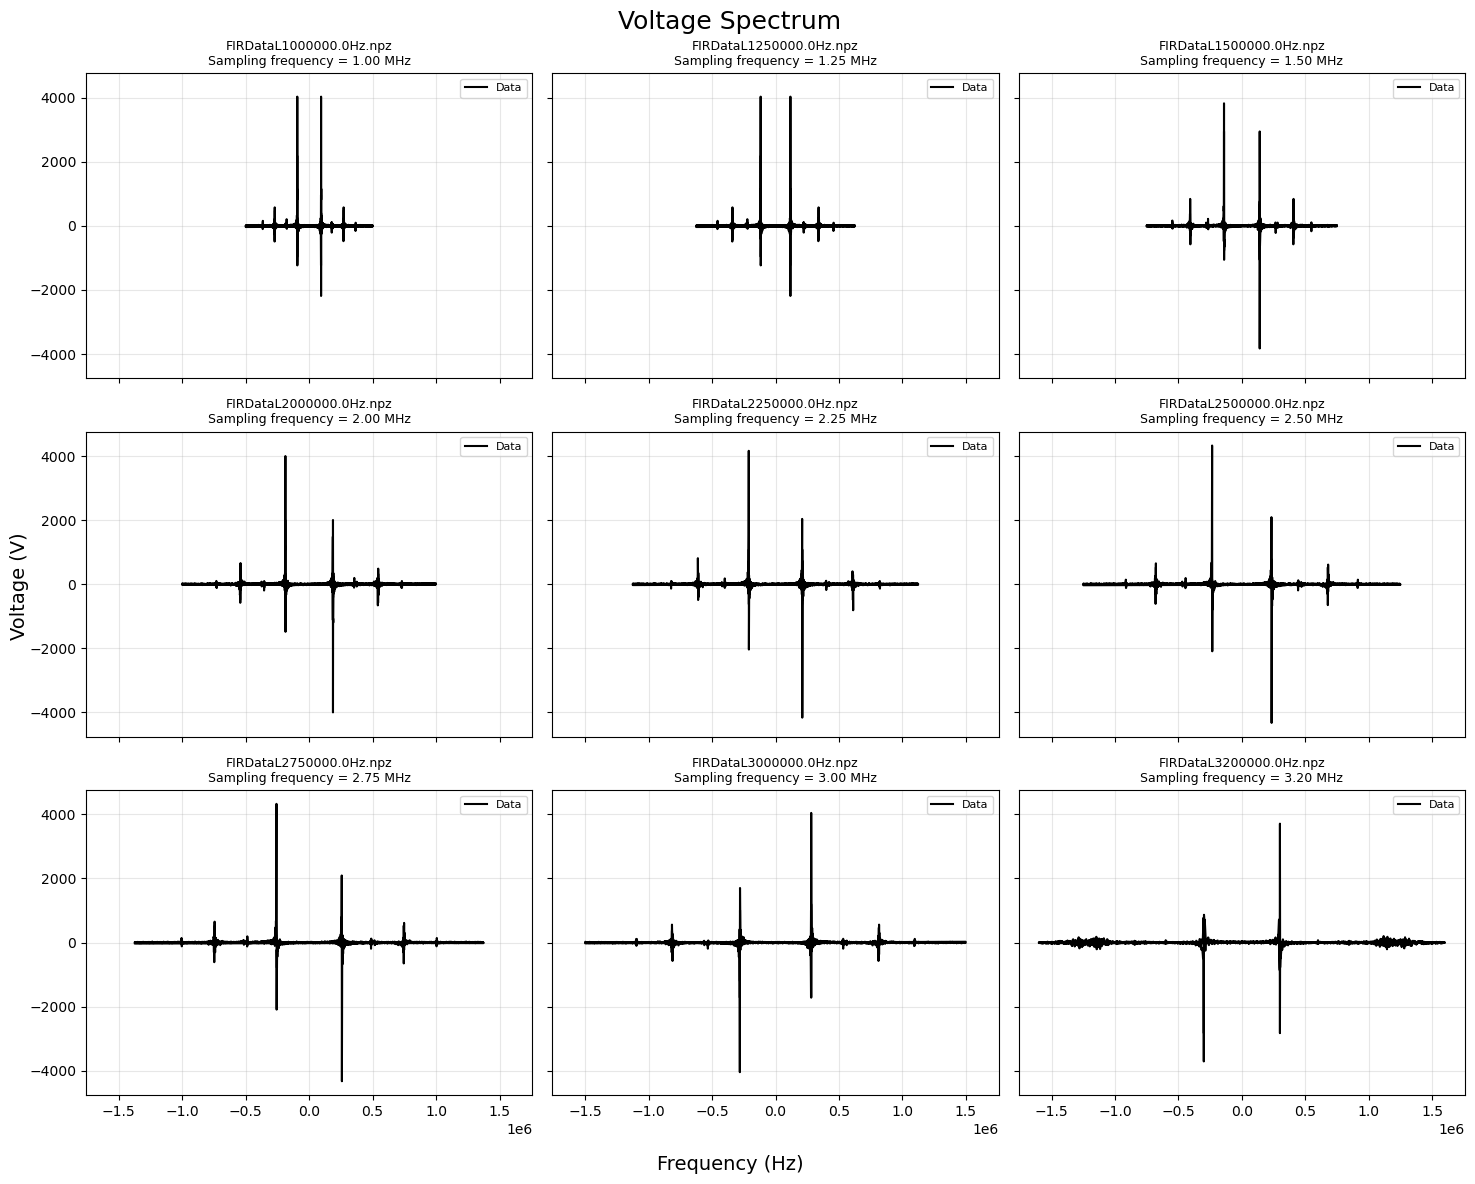

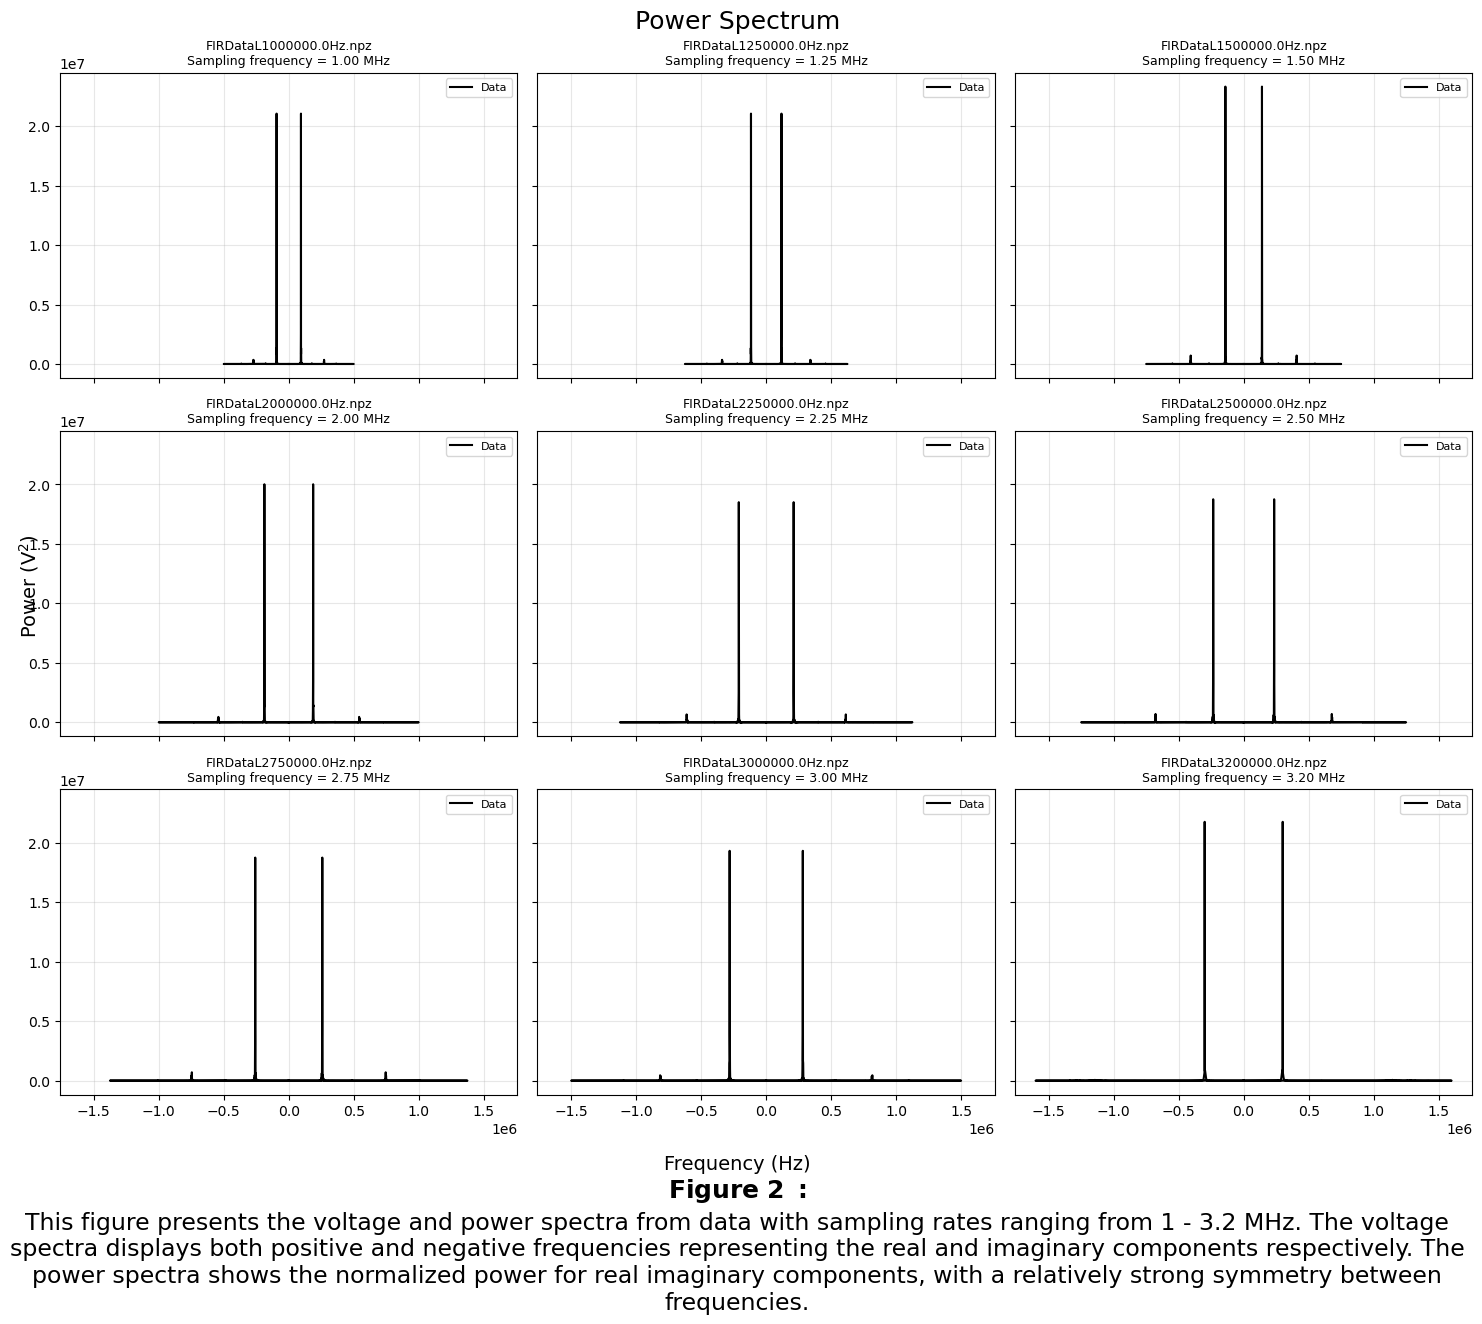

In [365]:
#Here we will plot the Voltage and Power Spectra for our data.

# -----------------------------
# Function to compute autocorrelation lags
# -----------------------------
def compute_lags(n, fs):
    return np.arange(-n+1, n)/fs

# -----------------------------
# Plot Voltage Spectrum
# -----------------------------
fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, fname in zip(axes, npz_files):
    npz = np.load(data_dir / fname)
    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"])
    y -= np.mean(y)  # remove DC
    Y = np.fft.fft(y)
    freqs = np.fft.fftfreq(len(y), d=1/fs)

    # Use filename frequency for label and window
    f_file = freq_from_filename(fname)

    ax.plot(freqs, np.real(Y), label="Data", color = 'black')
    ax.plot(freqs, np.imag(Y), color = 'black')
    ax.set_title(f"{fname}\nSampling frequency = {f_file/1e6:.2f} MHz", ha='center', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

fig.supxlabel("Frequency (Hz)", fontsize=14)
fig.supylabel("Voltage (V)", fontsize=14)
fig.suptitle("Voltage Spectrum", fontsize=18)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot Power Spectrum
# -----------------------------
fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, fname in zip(axes, npz_files):
    npz = np.load(data_dir / fname)
    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"])
    y -= np.mean(y)
    Y = np.fft.fft(y)
    P = np.abs(Y)**2
    freqs = np.fft.fftfreq(len(y), d=1/fs)
    
    # Use filename frequency for label and window
    f_file = freq_from_filename(fname)

    ax.plot(freqs, np.real(P), label="Data", color = 'black')
    ax.set_title(f"{fname}\nSampling frequency = {f_file/1e6:.2f} MHz", ha='center', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

fig.supxlabel("Frequency (Hz)", fontsize=14)
fig.supylabel("Power (V${^2}$)", fontsize=14)
fig.suptitle("Power Spectrum", fontsize=18)

caption = ( 
    "This figure presents the voltage and power spectra from data with sampling rates ranging from 1 - 3.2 MHz. " 
    "The voltage spectra displays both positive and negative frequencies representing the real and imaginary components respectively. " 
    "The power spectra shows the normalized power for real imaginary components, with a relatively strong symmetry between frequencies."
)
fig.text(0.5, -0.01,  r"$\bf{Figure\ 2\ :}$", ha='center', fontsize=18)

fig.text(
    0.5, -0.1, caption,
    ha='center',
    fontsize=17,
    wrap=True,
    bbox=dict(facecolor='white', alpha=0.0, boxstyle="round,pad=0.5")
)

# Make room for caption
plt.subplots_adjust(bottom=0.5)  # increase bottom margin

plt.tight_layout()
plt.show()

### The voltage spectra shows a clear difference with increasing sampling frequency. As the frequency increases, the imaginary and real components become less similar in magnitude. For the 1 MHz sampled waveform, the positive and negative frequencies had similar magnitudes. However, for the 3.2 MHz sampled wavee the positive and negative components were clearly different. As expected, the power spectrum showed very little difference in magnitude between sampling rates. However, it did display an increase in peak location of the frequency. The 1 MHz option displayed peaks closer to 100 kHz but with the higher sampling rate of 3.2 MHz on the peaks appeared to be closer to the true value of 300 kHz.

### Fourier transforms are supposed to maintain all information between transformations. Therefore it stands to reason that if one performs a Fourier transform and an inverse Fourier transform, the result should be the original information with no change. To test this theory, we will perform an inverse fast Fourier transform on the produced power spectra and see how that compares to the autocorrelation function from the voltage time series. The correlation theorem says that the Fourier transform of a correlation is the product of one Fourier transform with the complex conjugate of the other. The correlation involves "sliding" one signal past another to check similarities. If a Fourier transformation is truly information preserving, then correlating the signal with itself (autocorrelation) should poroduce the same figure as the Fourier transform of the correlation.

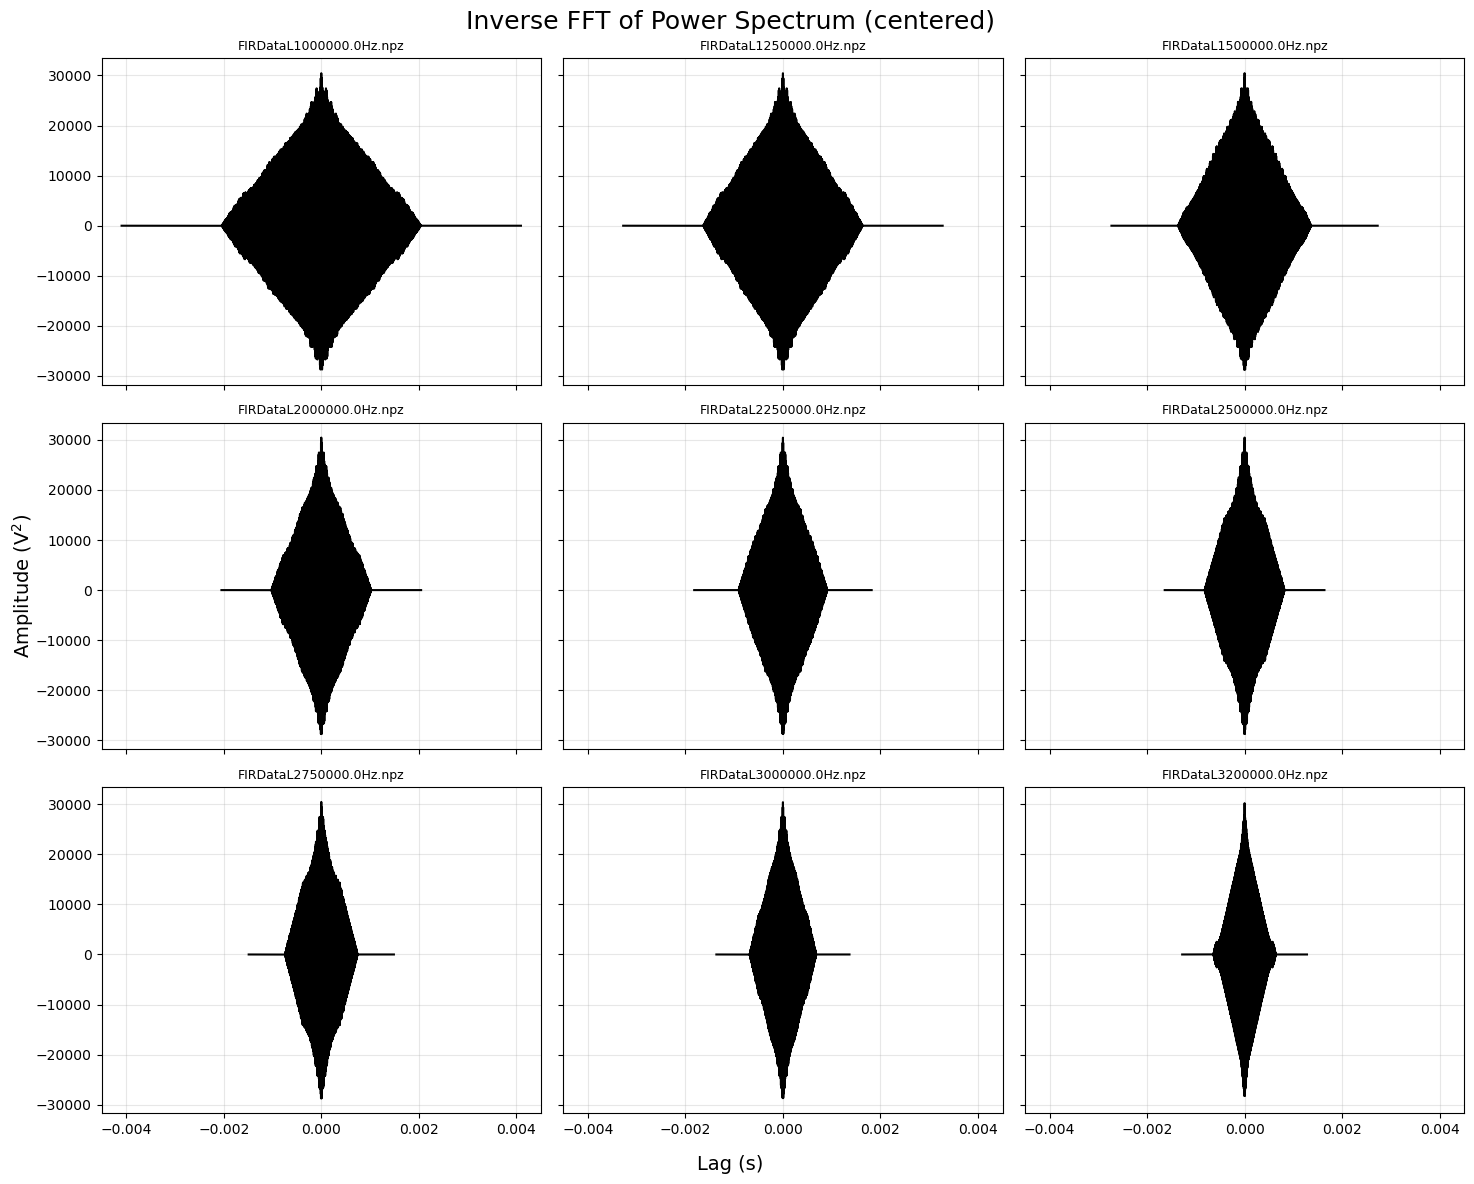

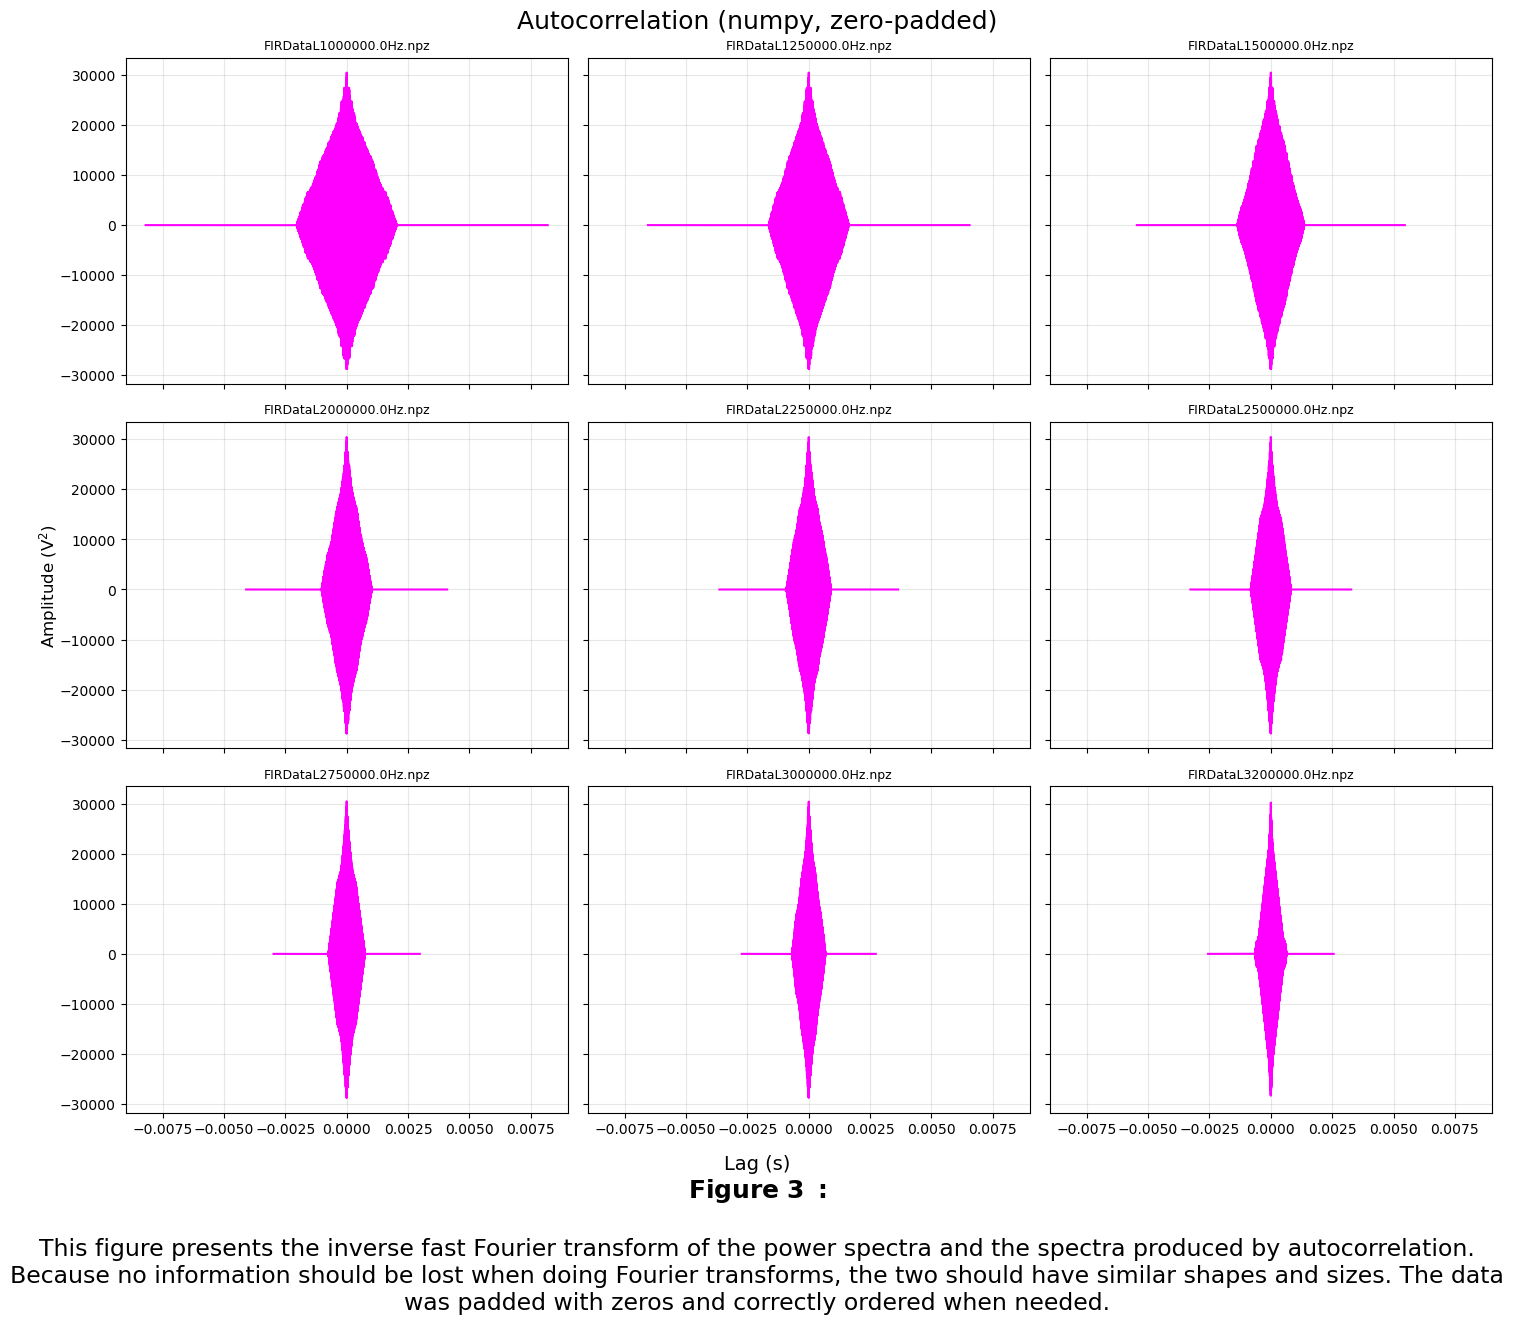

In [367]:
#Here we will plot the inverse FFT of the power spectra and the autocorrelation function for the data.

# Plot inverse FFT of power spectrum (aligned with autocorrelation)
fig, axes = plt.subplots(3,3, figsize=(15,12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, fname in zip(axes, npz_files):
    npz = np.load(data_dir / fname)
    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"])
    y -= np.mean(y)

    N_orig = len(y)
    N_pad = 4*N_orig
    y_padded = np.zeros(N_pad)
    y_padded[:N_orig] = y

    # FFT and Power Spectrum
    Y = np.fft.fft(y_padded)
    P = np.abs(Y)**2

    # Inverse FFT, then shift to center zero-lag
    y_ifft = np.fft.ifft(P)
    y_ifft_shifted = np.fft.fftshift(y_ifft)  # zero-lag in center

    # Lag axis
    lags = np.arange(-N_pad//2, N_pad//2)/fs

    ax.plot(lags, np.real(y_ifft_shifted), color = 'black')
    ax.set_title(fname, fontsize=9)
    ax.grid(True, alpha=0.3)

fig.supxlabel("Lag (s)", fontsize=14)
fig.supylabel("Amplitude (V${^2}$)", fontsize=14)
fig.suptitle("Inverse FFT of Power Spectrum (centered)", fontsize=18)
plt.tight_layout()
plt.show()

# Autocorrelation (numpy) for comparison
fig, axes = plt.subplots(3,3, figsize=(15,12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, fname in zip(axes, npz_files):
    npz = np.load(data_dir / fname)
    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"])
    y -= np.mean(y)

    N_orig = len(y)
    N_pad = 4*N_orig
    y_padded = np.zeros(N_pad)
    y_padded[:N_orig] = y

    acorr = np.correlate(y_padded, y_padded, mode='full')
    lags = np.arange(-N_pad+1, N_pad)/fs

    ax.plot(lags, acorr, color = 'magenta')
    ax.set_title(fname, fontsize=9)
    ax.grid(True, alpha=0.3)

fig.supxlabel("Lag (s)", fontsize=14)
fig.supylabel("Amplitude (V${^2}$)")
fig.suptitle("Autocorrelation (numpy, zero-padded)", fontsize=18)

caption = ( 
    "This figure presents the inverse fast Fourier transform of the power spectra and the spectra produced by autocorrelation. " 
    "Because no information should be lost when doing Fourier transforms, the two should have similar shapes and sizes. " 
    "The data was padded with zeros and correctly ordered when needed."
)
fig.text(0.5, -0.01,  r"$\bf{Figure\ 3\ :}$", ha='center', fontsize=18)

fig.text(
    0.5, -0.1, caption,
    ha='center',
    fontsize=17,
    wrap=True,
    bbox=dict(facecolor='white', alpha=0.0, boxstyle="round,pad=0.5")
)

# Make room for caption
plt.subplots_adjust(bottom=0.5)  # increase bottom margin

plt.tight_layout()
plt.show()


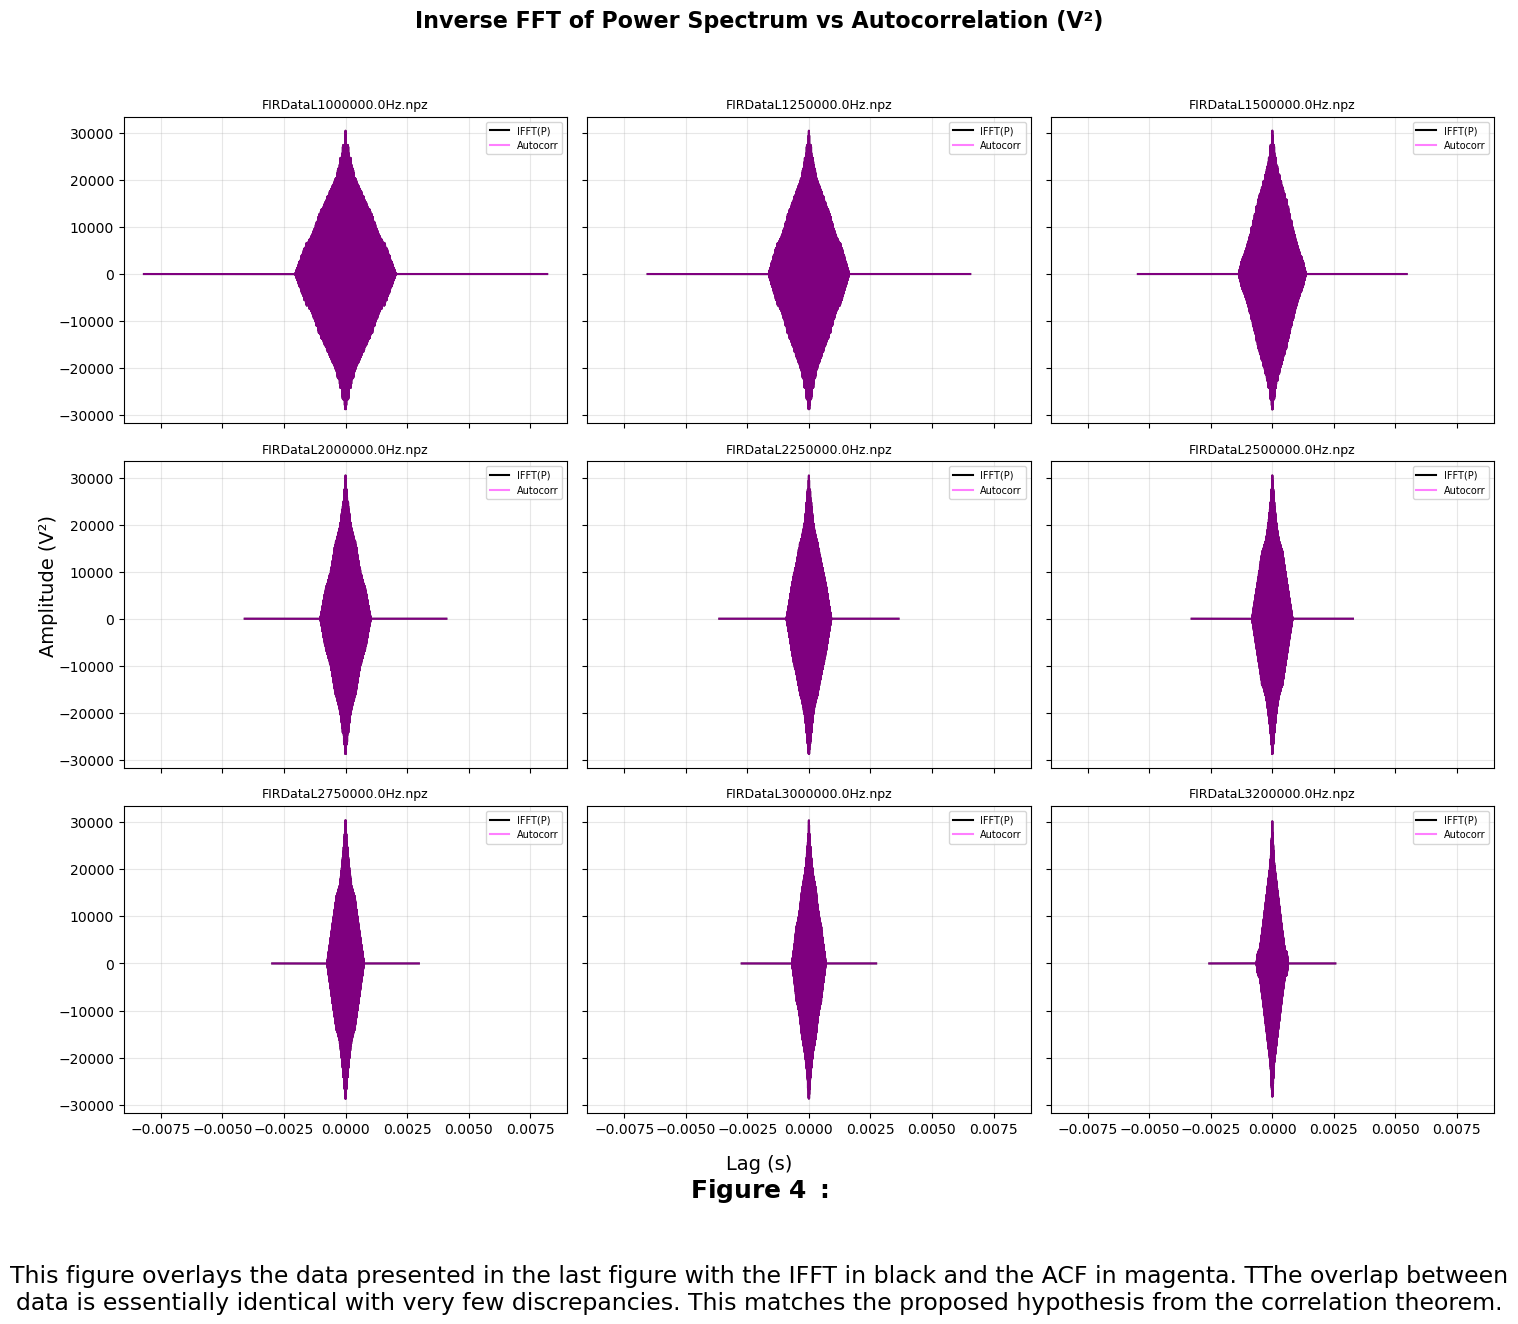

In [369]:
#Now lets overlay the IFFT of the power spectra over the ACF to look for similarities/differences.

# Zero-padding factor
ZERO_PAD_FACTOR = 4  

# -----------------------------
# Prepare figure
# -----------------------------
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, fname in zip(axes, npz_files):
    # Load data
    npz = np.load(data_dir / fname)
    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"])
    y -= np.mean(y)  # remove DC

    N_orig = len(y)
    N_pad = ZERO_PAD_FACTOR * N_orig

    # -----------------------------
    # Zero-pad the signal
    # -----------------------------
    y_padded = np.zeros(N_pad)
    y_padded[:N_orig] = y

    # -----------------------------
    # FFT and Power Spectrum
    # -----------------------------
    Y = np.fft.fft(y_padded)
    P = np.abs(Y)**2  # units V²

    # -----------------------------
    # Inverse FFT of Power Spectrum
    # -----------------------------
    y_ifft = np.fft.ifft(P)
    y_ifft_shifted = np.fft.fftshift(y_ifft)  # center zero-lag

    # -----------------------------
    # Autocorrelation (numpy)
    # -----------------------------
    acorr = np.correlate(y_padded, y_padded, mode='full')  # length = 2*N_pad -1

    # -----------------------------
    # Match IFFT length to autocorr
    # -----------------------------
    y_ifft_full = np.zeros(len(acorr), dtype=complex)
    start_idx = (len(acorr) - len(y_ifft_shifted)) // 2
    y_ifft_full[start_idx:start_idx + len(y_ifft_shifted)] = y_ifft_shifted

    # -----------------------------
    # Lag axis (seconds)
    # -----------------------------
    lags = np.arange(-N_pad + 1, N_pad) / fs  # length = 2*N_pad -1

    # -----------------------------
    # Plot both
    # -----------------------------
    ax.plot(lags, np.real(y_ifft_full), label="IFFT(P)", color = 'black')
    ax.plot(lags, acorr, alpha=0.5, label="Autocorr", color = 'magenta')
    ax.set_title(fname, fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7)

# -----------------------------
# Labels & layout
# -----------------------------
fig.suptitle("Inverse FFT of Power Spectrum vs Autocorrelation (V²)", fontsize=16, fontweight='bold')
fig.supxlabel("Lag (s)", fontsize=14)
fig.supylabel("Amplitude (V²)", fontsize=14)

caption = ( 
    "This figure overlays the data presented in the last figure with the IFFT in black and the ACF in magenta. " 
    "TThe overlap between data is essentially identical with very few discrepancies. " 
    "This matches the proposed hypothesis from the correlation theorem."
)
fig.text(0.5, -0.01,  r"$\bf{Figure\ 4\ :}$", ha='center', fontsize=18)

fig.text(
    0.5, -0.1, caption,
    ha='center',
    fontsize=17,
    wrap=True,
    bbox=dict(facecolor='white', alpha=0.0, boxstyle="round,pad=0.5")
)

# Make room for caption
plt.subplots_adjust(bottom=0.5)  # increase bottom margin

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()


### As you can see, the IFFT and ACF completely align with each other, showing that the Fourier transformation is truly information preserving. Therefore, correlating signals in time is equivalent to multiplying one spectrum by the complex conjugate of the other in frequency. The padding was necessary because the FFT assumes a periodic signal while autocorrelation is linear. Padding the data with zeros converts the FFT from circular to linear to match the autocorrelation. However, shifting back to the original focus on Nyquist frequencies, we can see that the aliasing drastically altered the shape of the correlation, with the lower sampling frequencies producing a much wider spectrum than the higher sampling frequencies. 

### The power spectrum is also helpful for plotting spectral leakage. Spectral leakage occurs when the energy from a signal doesn't fit into one exact FFT frequency bin, so it spills over (leaks) into the surrounding bins. A FFT assumes that our N samples represent exactly one period of a forever repeating signal, so if the frequency doesn't land on one of the discrete frequency points the function is forced to spread it across multiple bins. 

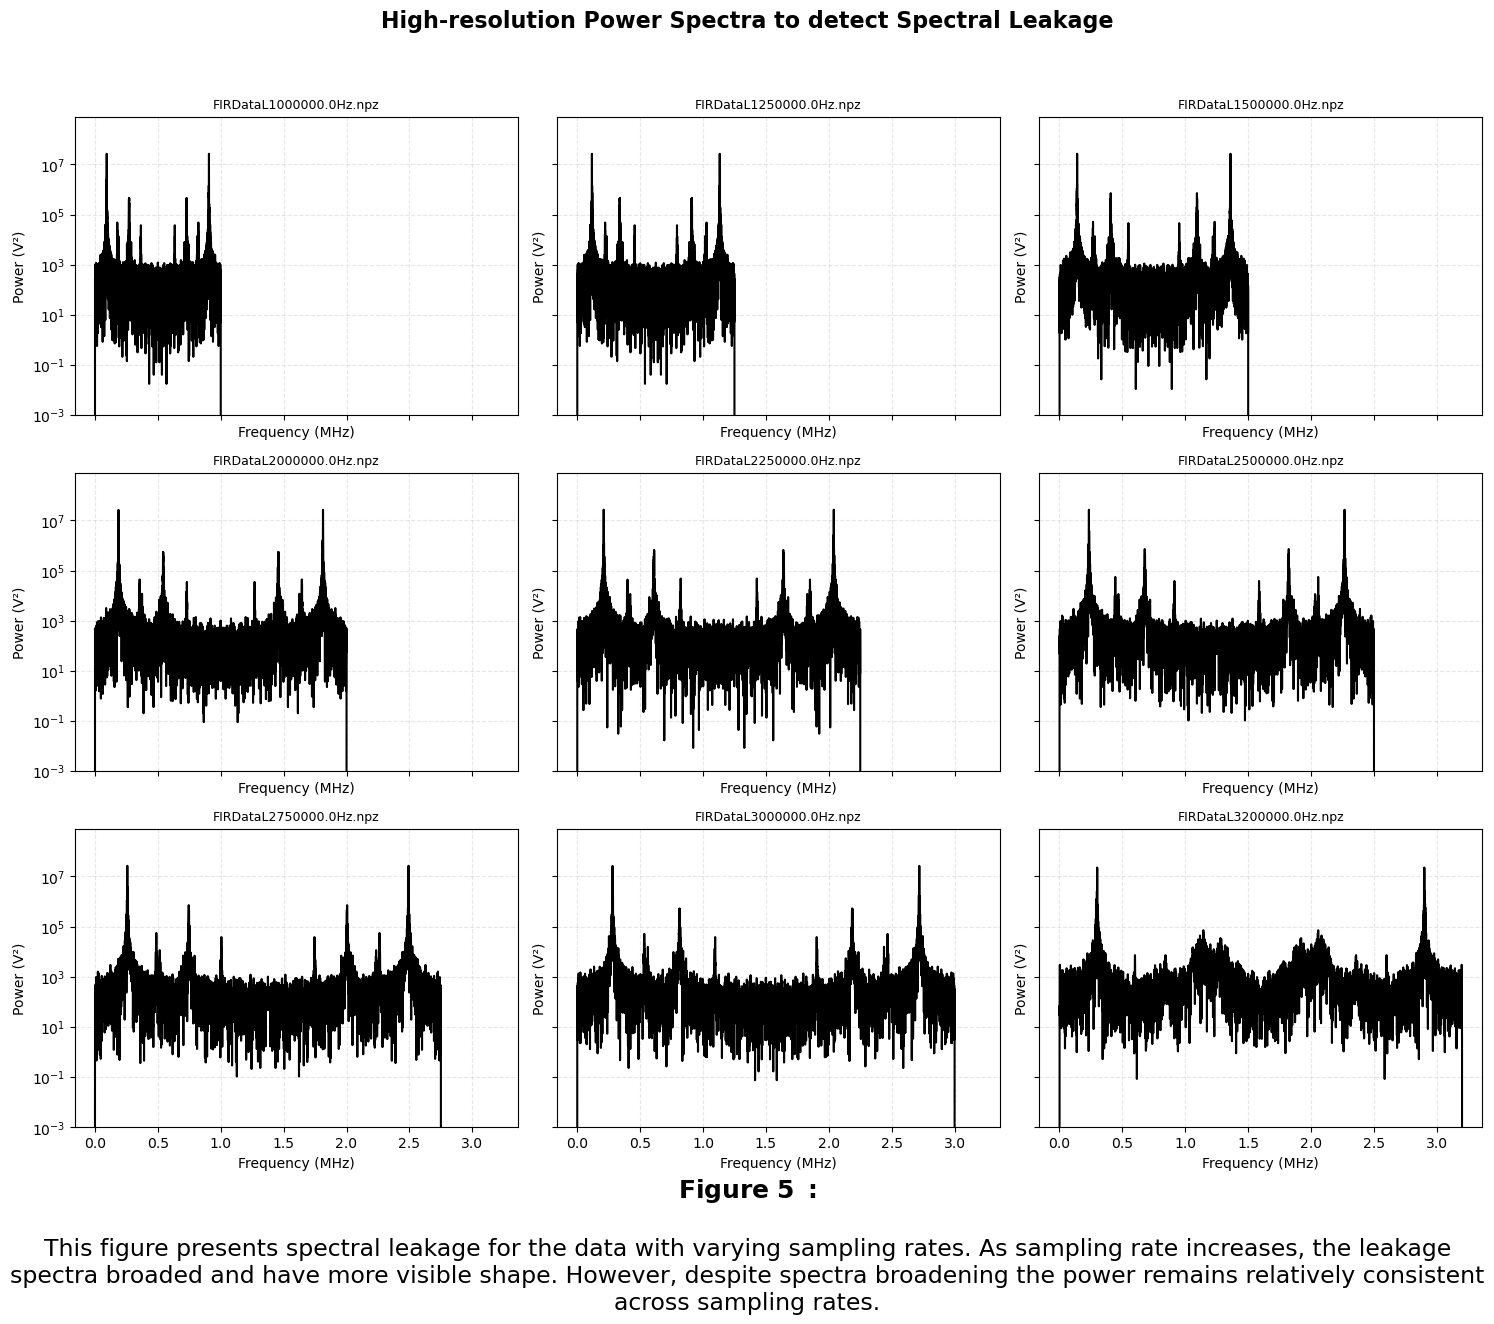

In [371]:
#Now we can plot for spectral leakage!

# Number of frequencies for high-resolution DFT
N_freq = 16384  # >> original N

# -----------------------------
# Prepare figure
# -----------------------------
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, fname in zip(axes, npz_files):
    # Load data
    npz = np.load(data_dir / fname)
    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"])
    y -= np.mean(y)  # remove DC

    N = len(y)
    t = np.arange(N) / fs

    # -----------------------------
    # High-resolution frequency grid
    # -----------------------------
    f_highres = np.linspace(0, fs, N_freq)

    # -----------------------------
    # Vectorized DFT
    # -----------------------------
    F = f_highres.reshape(-1, 1)  # shape (N_freq,1)
    Y = np.dot(np.exp(-2j * np.pi * F * t), y)
    P = np.abs(Y)**2

    # -----------------------------
    # Plot power spectrum (log scale)
    # -----------------------------
    ax.plot(f_highres / 1e6, P, color = 'black')  # convert Hz -> MHz for x-axis
    ax.set_yscale('log')
    ax.set_title(fname, fontsize=9)
    ax.grid(True, which='both', ls='--', alpha=0.3)
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Power (V²)")
    
    # -----------------------------
    # Set axis limits
    # -----------------------------
    #ax.set_xlim(f_highres[0]/1e6, f_highres[-1]/1e6)  # 0 to Nyquist
    ax.set_ylim(bottom = 10**(-3))             

# -----------------------------
# Main title & layout
# -----------------------------
fig.suptitle("High-resolution Power Spectra to detect Spectral Leakage", fontsize=16, fontweight='bold')

caption = ( 
    "This figure presents spectral leakage for the data with varying sampling rates. " 
    "As sampling rate increases, the leakage spectra broaded and have more visible shape. " 
    "However, despite spectra broadening the power remains relatively consistent across sampling rates."
)
fig.text(0.5, -0.01,  r"$\bf{Figure\ 5\ :}$", ha='center', fontsize=18)

fig.text(
    0.5, -0.1, caption,
    ha='center',
    fontsize=17,
    wrap=True,
    bbox=dict(facecolor='white', alpha=0.0, boxstyle="round,pad=0.5")
)

# Make room for caption
plt.subplots_adjust(bottom=0.5)  # increase bottom margin

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### By using a power splitter in reverse, we can select two close frequencies and combine their function generators. Using 300 kHz and 300.5 kHz functions, we can calculate the minmum distingushable spacing between lines based on the number of samples in a file. The frequency resolution of a FFT is directly impacted by the number of samples used as proved by the convolution theorem. 

### To start, the fundamental spacing between bins is defined as the sample frequency divided by the number of samples. Therefore a higher N leads to sharper and narrower spectral peaks. Using the convolution theorem, we can imagine sliding a rectangular window with a length of inverse bin spacing w(t)={1, 0${\le}$t<T , 0, elsewhere (T = N/f${_s}$) past our actual signal x(t). A multiplication in time corresponds to convolution in frequency. Therefore X${_N}$(f) = X(f) * W(f) = F{x(t)${\cdot}$w(t)}. Because the Fourier transform of a rectangular window of duration T is a sinc function, X${_N}$(f) = X(f) * [Tsinc(2${\pi}$fT)]. A larger T (more samples) means a narrower sinc function and therefore better resolution


FreqRes1000000.0Hz, 2048.npz: N=2048 → Δf=4.882812e+02 Hz
FreqRes1000000.0Hz, 4096.npz: N=2048 → Δf=4.882812e+02 Hz
FreqRes1000000.0Hz, 8192.npz: N=2048 → Δf=4.882812e+02 Hz
FreqRes1000000.0Hz, 16384.npz: N=2048 → Δf=4.882812e+02 Hz


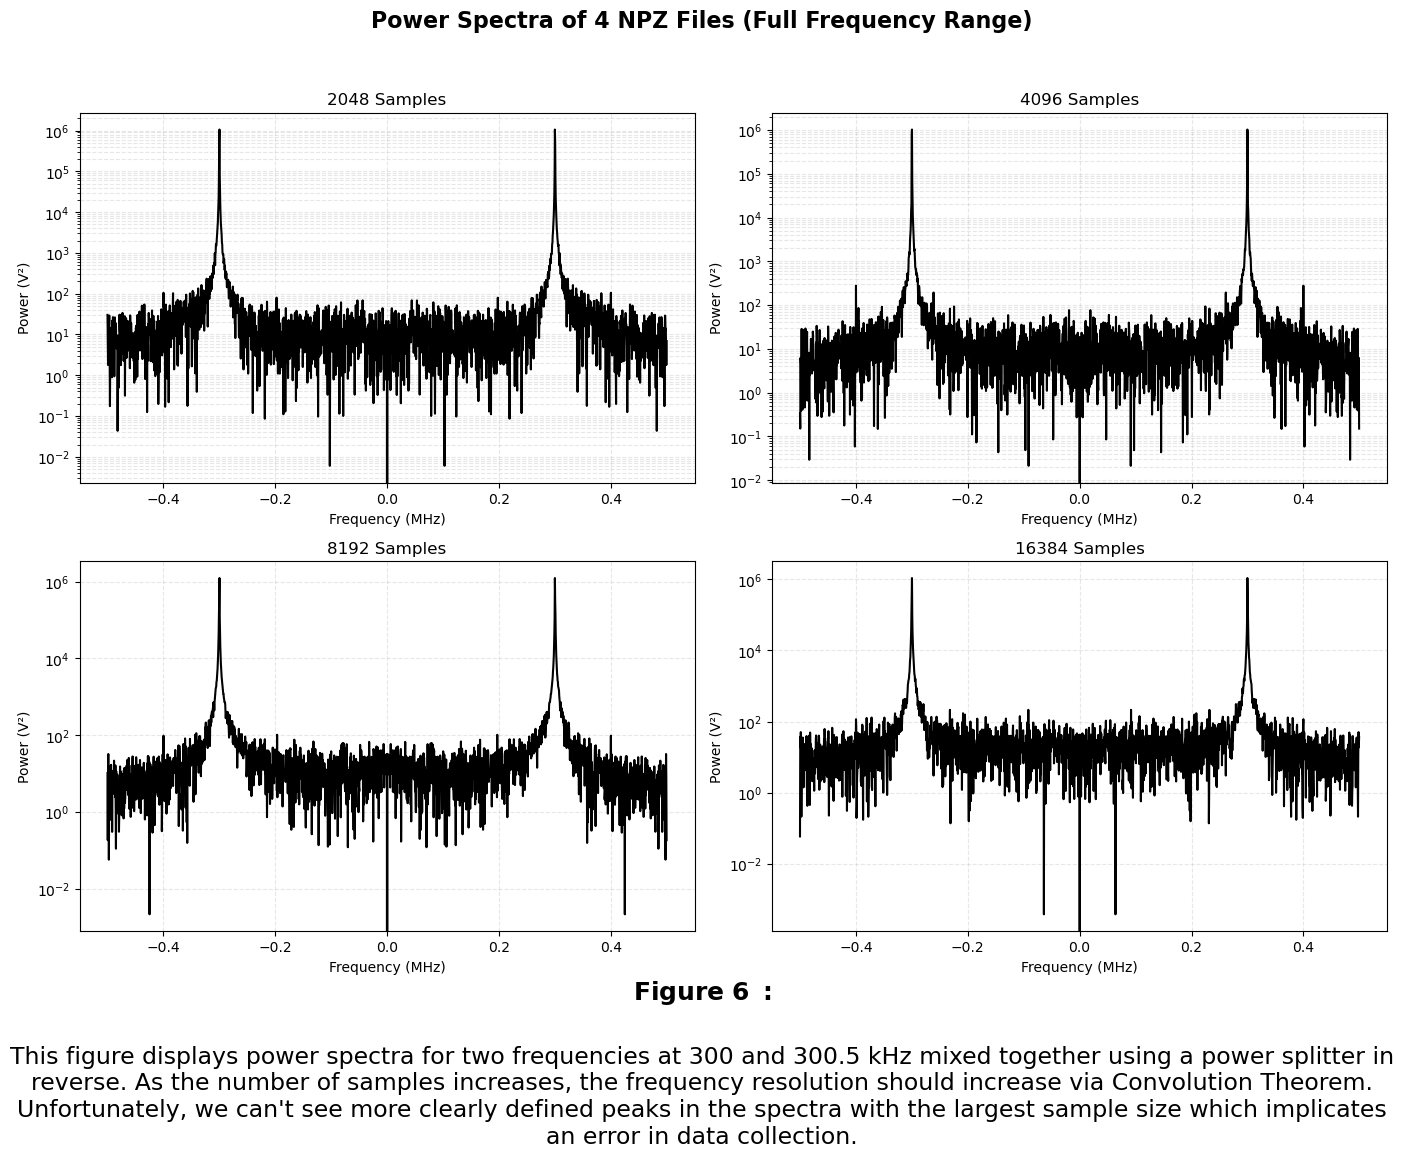

In [380]:
#Plot frequency resolution between 300 kHz and 300.5 kHz at varying sample numbers
# -----------------------------
# Configuration
# -----------------------------

data_dir = Path("./5.6/")
npz_files = [
    "FreqRes1000000.0Hz, 2048.npz",
    "FreqRes1000000.0Hz, 4096.npz",
    "FreqRes1000000.0Hz, 8192.npz",
    "FreqRes1000000.0Hz, 16384.npz",
]
titles = ["2048 Samples", "4096 Samples", "8192 Samples", "16384 Samples"]

colors = ['k', 'k', 'k', 'k']
# -----------------------------
# Prepare 2x2 grid
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# -----------------------------
# Loop over NPZ files
# -----------------------------
for ax, fname, title, color in zip(axes, npz_files, titles, colors):
    npz = np.load(data_dir / fname)
    y = npz["data"].astype(float)
    fs = float(npz["sample_rate"]) if "sample_rate" in npz.files else 1.0
    N = len(y)

    # Remove DC component
    y -= np.mean(y)

    # FFT
    Y = np.fft.fft(y)
    P = np.abs(Y)**2 / N  # Power spectrum
    f = np.fft.fftfreq(N, 1/fs)

    # Shift FFT and frequencies so zero is at center
    P_shifted = np.fft.fftshift(P)
    f_shifted = np.fft.fftshift(f)

    delta_f = fs / N
    print(f"{fname}: N={N} → Δf={delta_f:.6e} Hz")

    # Plot
    ax.plot(f_shifted/1e6, P_shifted, color=color, lw=1.5)
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Power (V²)")
    ax.set_title(title)
    ax.set_yscale("log")
    ax.grid(True, which='both', ls='--', alpha=0.3)

# -----------------------------
# Figure layout
# -----------------------------
plt.suptitle("Power Spectra of 4 NPZ Files (Full Frequency Range)", fontsize=16, fontweight='bold')

caption = ( 
    "This figure displays power spectra for two frequencies at 300 and 300.5 kHz mixed together using a power splitter in reverse. " 
    "As the number of samples increases, the frequency resolution should increase via Convolution Theorem. " 
    "Unfortunately, we can't see more clearly defined peaks in the spectra with the largest sample size which implicates an error in data collection."
)
fig.text(0.5, -0.01,  r"$\bf{Figure\ 6\ :}$", ha='center', fontsize=18)

fig.text(
    0.5, -0.15, caption,
    ha='center',
    fontsize=17,
    wrap=True,
    bbox=dict(facecolor='white', alpha=0.0, boxstyle="round,pad=0.5")
)

# Make room for caption
plt.subplots_adjust(bottom=0.5)  # increase bottom margin

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Unfortunately, it was realized too late that the code didn't actually take larger sample sizes as planned, so each file has the same length of 2048 samples rather than increasing values. Despite this setback, the math should hold true that resolution increases with sample size. 

### In the realm of measurements, there are several types of noise, many of which are unfortunately unavoidable. These types of noise include pink noise (1/f noise) which occurs everything, environmental noise which depends on location, shot noise which involves electric charges crossing a junction, and thermal noise (aka Johnson-Nyquist noise) which results from thermal motion of charged particles. Thermal noise is particularly common in astrophysics as it exists in any resistor, is independent of current flow, and is essentially unavoidable. This makes it different from systematic errors or bias as it is a fundamental property of the equipment that can't be removed, only reduced. Thermal noise typically follows a Gaussian distribution, as the central limit theorem says that adding a large number of independent random variables tends toward such a distribution. In order to learn more about noise in measurements, a noise generator was used to test whether or not noise follows such a distribution and how we can reduce it. 

Mean voltage: -8.04276 V
Variance: 332.25888 V²
RMS voltage (std): 18.22797 V


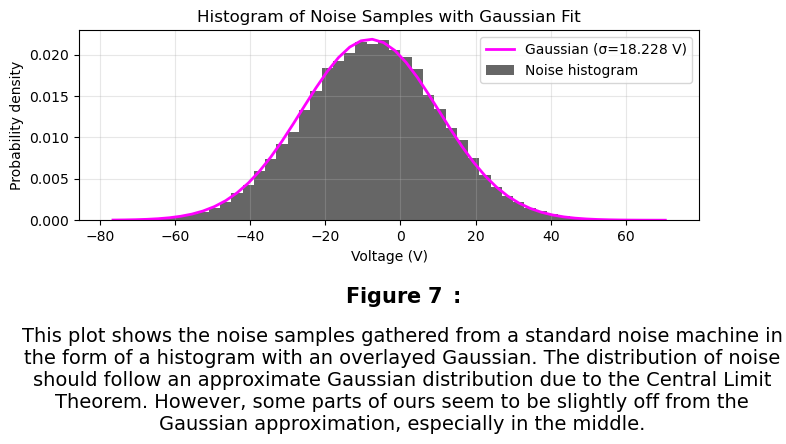

In [384]:
#Histogram of noise data w/ overlayed Gaussian
# -----------------------------
# Load noise data
# -----------------------------
data_file = Path("./5.8/")
npz = np.load(data_file / "noise_1000000Hz_2blocks, 65536samples.npz")
y = npz["data"].astype(float)  # assuming 'data' contains the noise samples

# -----------------------------
# Compute statistics
# -----------------------------
mean_y = np.mean(y)
rms_y = np.std(y)  # standard deviation = RMS voltage for zero-mean noise
var_y = np.var(y)

print(f"Mean voltage: {mean_y:.5f} V")
print(f"Variance: {var_y:.5f} V²")
print(f"RMS voltage (std): {rms_y:.5f} V")

# -----------------------------
# Histogram
# -----------------------------
num_bins = 50
hist_counts, bin_edges = np.histogram(y, bins=num_bins, density=True)

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# -----------------------------
# Theoretical Gaussian
# -----------------------------
gauss_pdf = norm.pdf(bin_centers, loc=mean_y, scale=rms_y)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8,5))
plt.bar(bin_centers, hist_counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Noise histogram", color = 'black')
plt.plot(bin_centers, gauss_pdf, '-', color = 'magenta', lw=2, label=f"Gaussian (σ={rms_y:.3f} V)")
plt.xlabel("Voltage (V)")
plt.ylabel("Probability density")
plt.title("Histogram of Noise Samples with Gaussian Fit")
plt.legend()
plt.grid(alpha=0.3)

caption = ( 
    "This plot shows the noise samples gathered from a standard noise machine in the form of a histogram with an overlayed Gaussian. " 
    "The distribution of noise should follow an approximate Gaussian distribution due to the Central Limit Theorem. " 
    "However, some parts of ours seem to be slightly off from the Gaussian approximation, especially in the middle."
)
plt.text(0.5, -0.01,  r"$\bf{Figure\ 7\ :}$", ha='center', fontsize=15)

plt.text(
    0.5, -0.025, caption,
    ha='center',
    fontsize=14,
    wrap=True,
    bbox=dict(facecolor='white', alpha=0.0, boxstyle="round,pad=0.5")
)

# Make room for caption
plt.subplots_adjust(bottom=0.5)  # increase bottom margin

plt.show()


### As expected, the noise histogram followed a relatively Gaussian distribution with only some slight variation in the middle and on the sides. This error could possibly be attributed to the type of low-pass filter used to prevent aliasing, which may have created some type of bias in the noise sampling. 

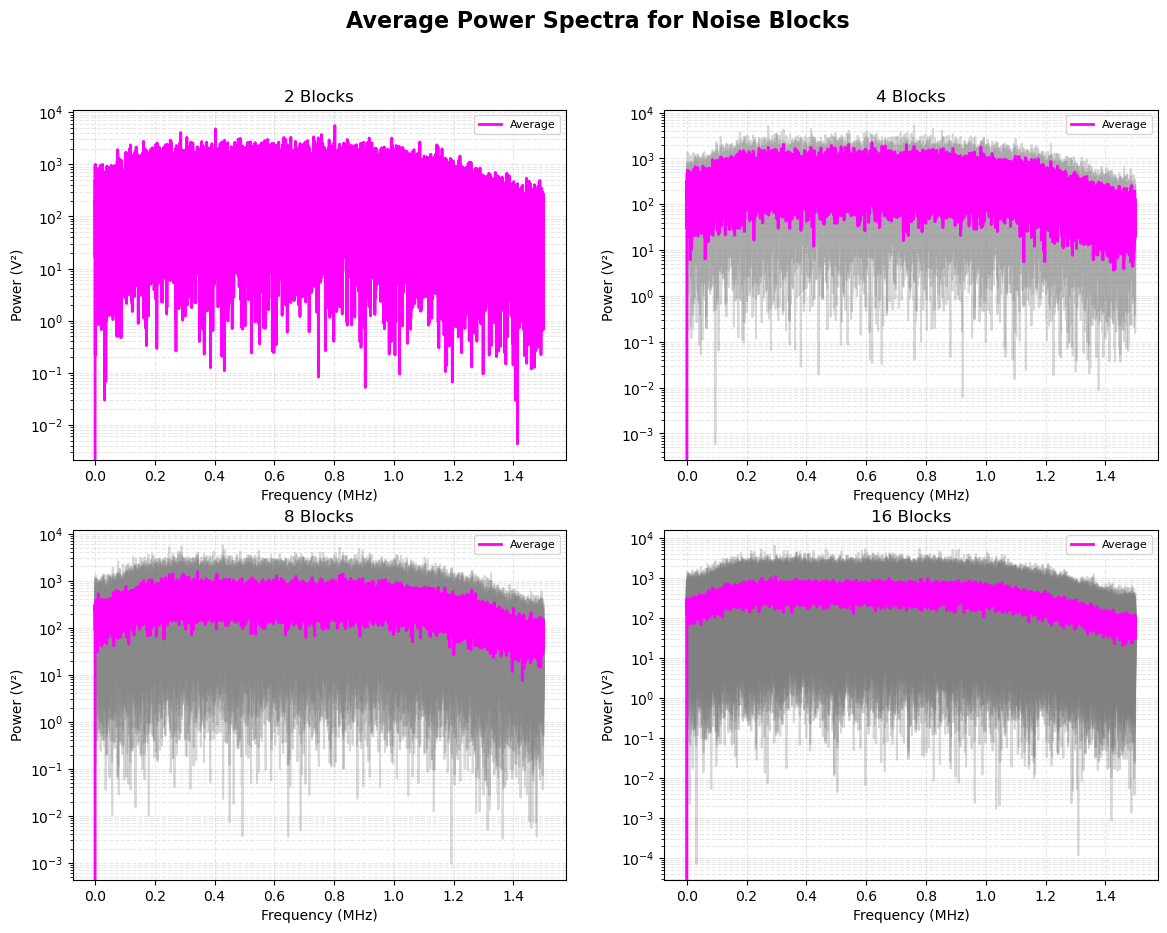

In [387]:

# -----------------------------
# Configuration
# -----------------------------
data_dir = Path("./5.8/")
npz_files = [
    "noise_1000000Hz_2blocks, 65536samples.npz",
    "noise_1000000Hz_4blocks, 65536samples.npz",
    "noise_1000000Hz_8blocks, 65536samples.npz",
    "noise_1000000Hz_16blocks, 65536samples.npz",
]
titles = ["2 Blocks", "4 Blocks", "8 Blocks", "16 Blocks"]

# -----------------------------
# Prepare figure
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# -----------------------------
# Loop over NPZ files
# -----------------------------
for ax, fname, title in zip(axes, npz_files, titles):
    # Load NPZ
    npz = np.load(data_dir / fname)
    y_blocks = npz["data"].astype(float)  # shape: (n_blocks, N_samples)
    fs = float(npz["sample_rate"]) if "sample_rate" in npz.files else 1.0

    ps_list = []
    for y in y_blocks:
        y -= np.mean(y)  # remove DC
        N = len(y)
        Y = np.fft.fft(y)
        P = (np.abs(Y)**2) / N  # normalize by N
        f = np.fft.fftfreq(N, 1/fs)
        pos_mask = f >= 0
        ps_list.append(P[pos_mask])
        f_pos = f[pos_mask]

    # Average power spectrum
    ps_avg = np.mean(np.array(ps_list), axis=0)

    # -----------------------------
    # Plot
    # -----------------------------
    # Plot individual blocks faintly
    for P in ps_list:
        ax.plot(f_pos/1e6, P, color='gray', alpha=0.3)

    # Plot average spectrum
    ax.plot(f_pos/1e6, ps_avg, '-', color = 'magenta', lw=2, label="Average")

    ax.set_yscale("log")
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Power (V²)")
    ax.set_title(title)
    ax.grid(True, which='both', ls='--', alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle("Average Power Spectra for Noise Blocks", fontsize=16, fontweight='bold')
plt.show()


# Figure 8:

This figure displays the spectrum of various N blocks of data in the first four powers of 2 (2, 4, 8, 16). As the number of blocks increases, the distribution of the averaged power spectrum decreases. This shows that the largest number of blocks, with the most averaging, has the thinnest distribution of power. This aligns with the theory that time averaging scales the signal-to-noise ratio in line with the Central Limit Theorem."

### Based on the number of samples of noise taken we can clearly see a decrease in the power dispersion as the number of samples increases. This can be explained by time averaging, which increases the signal-to-noise ratio. Because noise is essentially random, it is likely that averaging noise together will cause the majority of it to add destructively while the signal itself adds constructively. This enhances the overall strength of the signal while reducing the intensity of the noise around it. This can be proven mathematically by considering that the noise RMS is represented as ${\sigma}_{avg}$ = ${\sigma}$/${\sqrt{N}}$ . SNR = signal/${\sigma}$ = SNR$_{0}$${\sqrt{N}}$ which means that SNR $\propto$ N$^{1/2}$. This is supported by the central limit theorem which predicts the sum of N independent noise samples has variance N${\sigma}^{2}$ which supports idea that time average improves SNR.

Loaded 1 blocks, each with 16384 samples, fs = 3000000.0 Hz
FWHM of ACF (Gaussian fit): -4.134106e-07 s
FWHM of ACF: -4.134106e-07 s
FWHM of power spectrum: 8.733829e+05 Hz


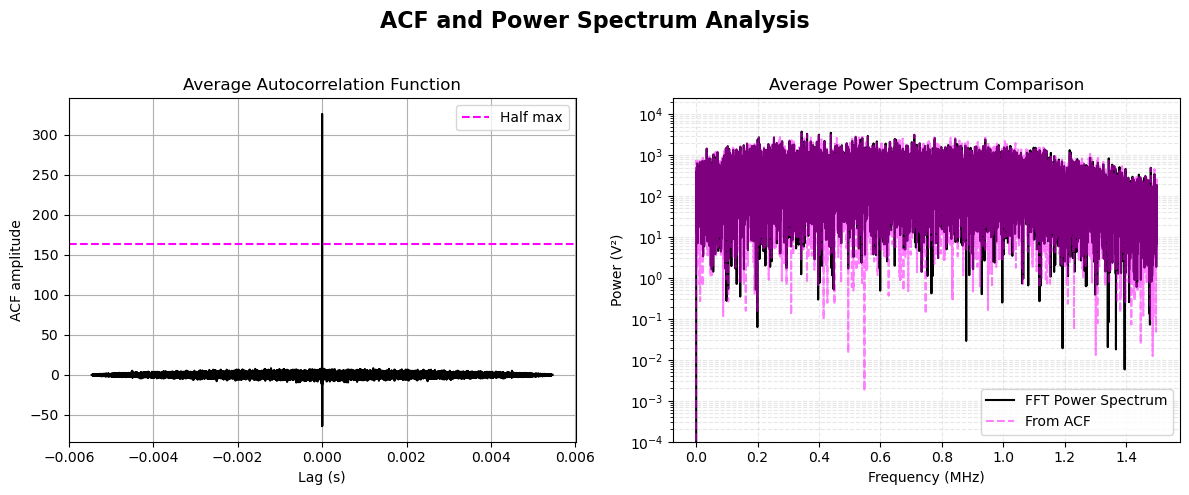

In [398]:
#ACF for a 16,0000 sample block
# -----------------------------
# Compute FWHM
# -----------------------------
def compute_fwhm(x, y):
    """
    Compute FWHM of a peak in y(x) using linear interpolation.
    Returns NaN if no half-max points are found.
    """
    y = np.array(y)
    x = np.array(x)
    
    y_max = np.max(y)
    half_max = y_max / 2

    # Indices where y crosses half-max
    indices = np.where(y >= half_max)[0]
    if len(indices) < 2:
        return np.nan  # not enough points to define FWHM

    left_idx = indices[0]
    right_idx = indices[-1]

    # Linear interpolation for left half-max
    if left_idx == 0:
        x_left = x[0]
    else:
        x1, x2 = x[left_idx-1], x[left_idx]
        y1, y2 = y[left_idx-1], y[left_idx]
        x_left = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)

    # Linear interpolation for right half-max
    if right_idx == len(y)-1:
        x_right = x[-1]
    else:
        x1, x2 = x[right_idx], x[right_idx+1]
        y1, y2 = y[right_idx], y[right_idx+1]
        x_right = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)

    return x_right - x_left

# -----------------------------
# Load blocked NPZ file
# -----------------------------
data_file = Path("./5.8/noise_1000000Hz_2blocks, 16384samples.npz")
npz = np.load(data_file)

# Assume blocks are stored in a 2D array "data": shape (n_blocks, N_samples)
y_blocks = npz["data"].astype(float)
fs = float(npz["sample_rate"]) if "sample_rate" in npz.files else 1.0
n_blocks, N = y_blocks.shape

print(f"Loaded {n_blocks} blocks, each with {N} samples, fs = {fs} Hz")

# -----------------------------
# Compute ACF, FFT, and power spectrum from ACF
# -----------------------------
acf_list, ps_from_acf_list, ps_fft_list = [], [], []

for y in y_blocks:
    y -= np.mean(y)  # remove DC

    # --- Autocorrelation ---
    acf = correlate(y, y, mode='full') / N
    lags = np.arange(-N+1, N) / fs
    acf_list.append(acf)

    # --- Power spectrum from ACF (Wiener–Khinchin theorem) ---
    ps_from_acf = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(acf)))
    f_acf = np.fft.fftshift(np.fft.fftfreq(len(acf), 1/fs))
    ps_from_acf_list.append(np.abs(ps_from_acf))

    # --- Direct FFT power spectrum ---
    Y = np.fft.fft(y)
    f_fft = np.fft.fftfreq(N, 1/fs)
    ps_fft = np.abs(Y)**2 / N
    pos_mask = f_fft >= 0
    ps_fft_list.append(ps_fft[pos_mask])
    f_fft_pos = f_fft[pos_mask]

# -----------------------------
# Average across blocks
# -----------------------------
acf_avg = np.mean(np.array(acf_list), axis=0)
ps_acf_avg = np.mean(np.array(ps_from_acf_list), axis=0)
ps_fft_avg = np.mean(np.array(ps_fft_list), axis=0)

# -----------------------------
# Compute FWHM
# -----------------------------
from scipy.optimize import curve_fit
import numpy as np

# Gaussian function
def gaussian(x, A, sigma):
    return A * np.exp(-0.5*(x/sigma)**2)

center = len(acf_avg)//2
# Take ~10 points around the peak
window = 5  # adjust if your sampling is very coarse
lags_window = lags[center-window:center+window+1]
acf_window = acf_avg[center-window:center+window+1]

# Fit Gaussian
popt, _ = curve_fit(gaussian, lags_window, acf_window, p0=[acf_avg[center], 1e-6])
sigma = popt[1]

# Convert sigma to FWHM
fwhm_acf = 2.3548 * sigma
print(f"FWHM of ACF (Gaussian fit): {fwhm_acf:.6e} s")

# Positive frequency portion for FWHM
f_pos_mask = f_acf >= 0
ps_acf_pos = ps_acf_avg[f_pos_mask]
f_pos = f_acf[f_pos_mask]
fwhm_ps = compute_fwhm(f_pos, ps_acf_pos)

print(f"FWHM of ACF: {fwhm_acf:.6e} s")
print(f"FWHM of power spectrum: {fwhm_ps:.6e} Hz")

# -----------------------------
# Plotting
# -----------------------------
plt.figure(figsize=(12,5))

# --- ACF ---
plt.subplot(1,2,1)
plt.plot(lags, acf_avg, color = 'black')
plt.title("Average Autocorrelation Function")
plt.xlabel("Lag (s)")
plt.ylabel("ACF amplitude")
plt.grid(True)
plt.axhline(np.max(acf_avg)/2, color='magenta', linestyle='--', label='Half max')
plt.legend()

# --- Power spectrum comparison ---
plt.subplot(1,2,2)
plt.plot(f_fft_pos/1e6, ps_fft_avg, label="FFT Power Spectrum", color = 'black')
plt.plot(f_pos/1e6, ps_acf_pos, '--', label="From ACF", color = 'magenta', alpha = 0.5)
plt.title("Average Power Spectrum Comparison")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (V²)")
plt.yscale("log")
plt.ylim(bottom = 10**-4)
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()

plt.suptitle("ACF and Power Spectrum Analysis", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Figure 9:
On the right this figure shows the autocorrelation function for a 16,000 sample block. On the left is the power spectrum derived from the ACF compard to the IFFT of the power spectrum for the same data. There is a very similar overlap between the ACF and IFFT however there are some points where it seems like the lower boundary of data does not align.

### Mixers are important because they help you keep the frequency information that you want, improve SNR, and preserve the sign of frequency shifts. They mix a signal with local oscillator (LO) creating an upper sideband (f$_{RF}$ + f$_{LO}$) and a lower sideband (f$_{RF}$ - f$_{LO}$). These sidebands tell you where the signal energy goes when the signal is mixed and affect how that signal is processed. The most basic type of mixer is a double sideband mixer (DSB) which gives you both an upper and a lower sideband by either having a higher or lower LO frequency. A DSB was created with a RF of 200 kHz and a ${\Delta}{\nu}$ of ${\pm}$10 kHz.

Number of samples: 16384, Frequency resolution Δf = 6.103516e+01 Hz


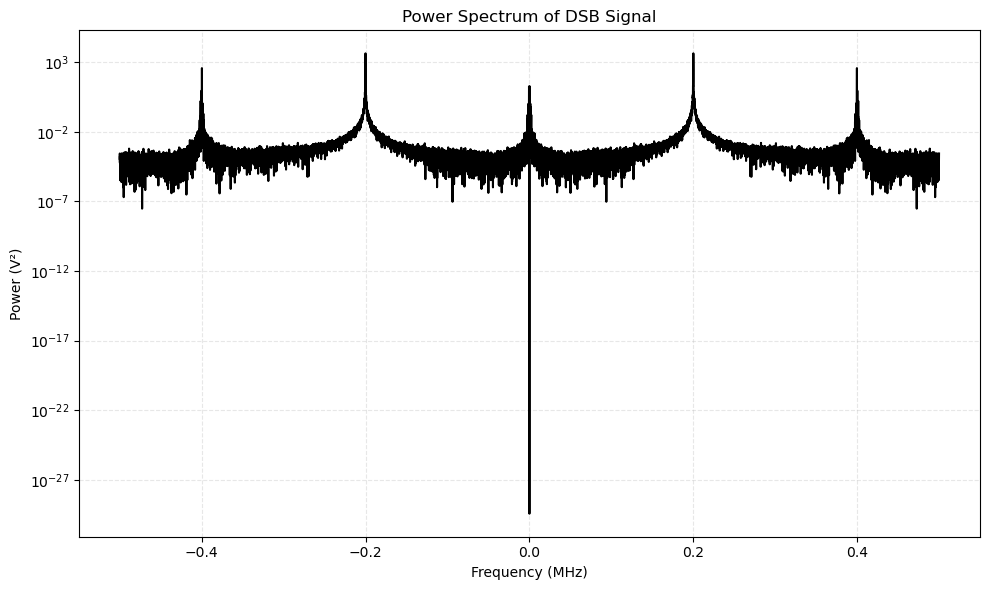

In [405]:
#DSB Data

# -----------------------------
# Configuration
# -----------------------------
data_file = Path("./7.1/dsb_IF_RF9p8_LO10_fs1MHz.npz")
npz = np.load(data_file)

y = npz["data"].astype(float)             # Signal
fs = float(npz["sample_rate"])            # Sampling frequency
N = len(y)

# -----------------------------
# Remove DC offset
# -----------------------------
y -= np.mean(y)

# -----------------------------
# FFT and Power Spectrum
# -----------------------------
Y = np.fft.fft(y)
P = np.abs(Y)**2 / N  # Power spectrum

f = np.fft.fftfreq(N, 1/fs)

# Shift FFT so zero frequency is at center
P_shifted = np.fft.fftshift(P)
f_shifted = np.fft.fftshift(f)

# Frequency resolution
delta_f = fs / N
print(f"Number of samples: {N}, Frequency resolution Δf = {delta_f:.6e} Hz")

# -----------------------------
# Plot Power Spectrum
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(f_shifted/1e6, P_shifted, color='k', lw=1.5)
plt.title("Power Spectrum of DSB Signal")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (V²)")
plt.yscale("log")
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Figure 10: 

This figure displays the power spectrum produced by the Double-Sideband mixer with a LO of 200 kHz and an RF of 210 kHz. The waveform was sampled at 1 MHz, which should be well above the Nyquist frequency. This plot represents the upper sideband of the DSB where the RF is the sum frequency rather than the difference frequency. 

### Unfortunately, due to an error while collecting data, only the upper sideband of the DSB was maintained. This is likely because we forgot to change the name of the file before running the code which overwrote the lower sideband data. This type of error will be fixed in the next lab by using for loops to ensure that different names are made for data and double checking all data is present before continuing. 

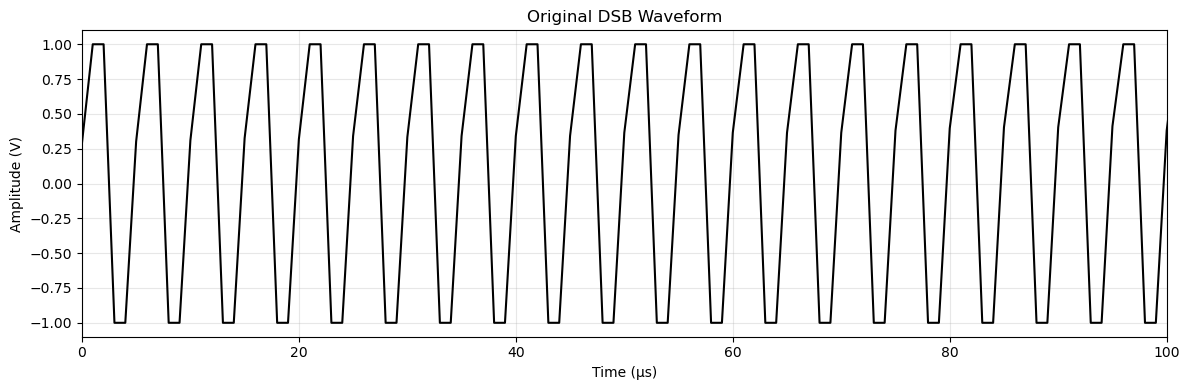

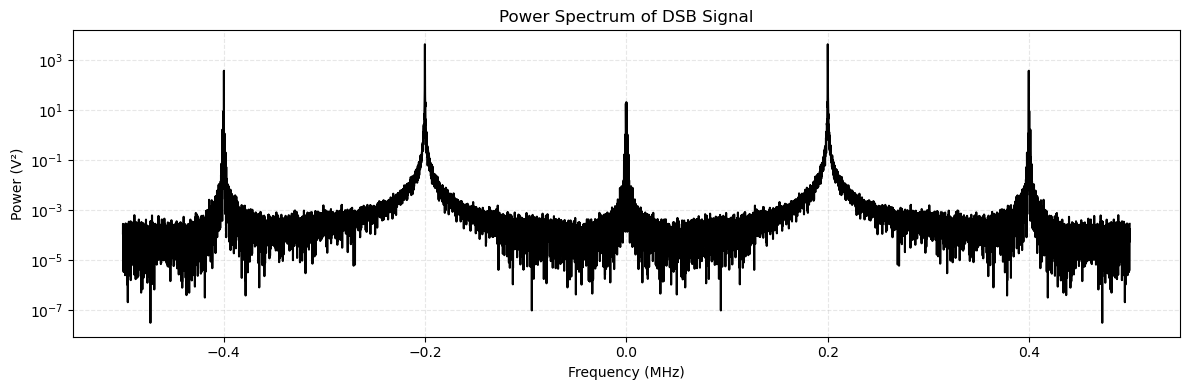

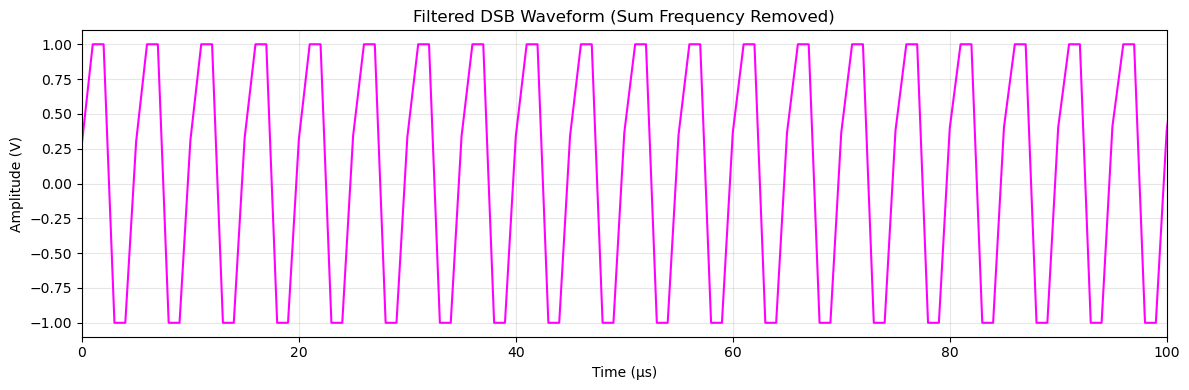

In [418]:

# -----------------------------
# Load DSB NPZ file
# -----------------------------
data_file = Path("./7.1/dsb_IF_RF9p8_LO10_fs1MHz.npz")
npz = np.load(data_file)

y = npz["data"].astype(float)
fs = float(npz["sample_rate"])
N = len(y)
t = np.arange(N) / fs

# -----------------------------
# Plot original waveform
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(t*1e6, y, lw=1.5, color = 'black')
plt.title("Original DSB Waveform")
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude (V)")
plt.xlim(left = 0, right = 100)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# FFT of the signal
# -----------------------------
Y = np.fft.fft(y)
f = np.fft.fftfreq(N, 1/fs)

# Shift for visualization
Y_shifted = np.fft.fftshift(Y)
f_shifted = np.fft.fftshift(f)

# Plot power spectrum for reference
plt.figure(figsize=(12,4))
plt.plot(f_shifted/1e6, np.abs(Y_shifted)**2 / N, lw=1.5, color = 'black')
plt.title("Power Spectrum of DSB Signal")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (V²)")
plt.yscale("log")
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Filter sum (upper) frequency
# -----------------------------
# Example: zero out positive frequencies above carrier frequency
# You can adjust this range according to your DSB carrier frequency
carrier_freq = 5e6  # example carrier frequency in Hz
bandwidth = 1e6     # example bandwidth to keep

# Identify positive and negative frequency indices
pos_idx = (f > carrier_freq + bandwidth/2)
neg_idx = (f < -carrier_freq - bandwidth/2)

Y_filtered = Y.copy()
Y_filtered[pos_idx] = 0
Y_filtered[neg_idx] = 0

# -----------------------------
# Inverse FFT to get filtered waveform
# -----------------------------
y_filtered = np.fft.ifft(Y_filtered).real

# -----------------------------
# Plot filtered waveform
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(t*1e6, y_filtered, lw=1.5, color='magenta')
plt.title("Filtered DSB Waveform (Sum Frequency Removed)")
plt.xlabel("Time (µs)")
plt.ylabel("Amplitude (V)")
plt.xlim(left = 0, right = 100)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Figure 11:

This figure shows the waveform of the upper sideband, its subsequent power spectrum, and then an IFFT of the aforementioned power spectrum. The sum frequency has been filtered by zeroing it in the Fourier domain. Due to the nature of a Fourier Transform, there shouldn't be any information lost, which we can see as the waveforms appear identical.

### The double sideband signal in the time domain shows rapid oscillations modulated by an envelope. The FFT of the DSB signal shows two symmetric peaks at +${\Delta}{\nu}$ and -${\Delta}{\nu}$. The inverse DSB waveform shows a similar envelope as the original waveform. However, the filtered envelope has a slight waveform distortion due to the removal of the upper sideband.

### The other type of mixer investigated is the single sideband mixer which uses two DSB mixers. In this case, a phase shifted function generator mixes a cosine with a sin producing real (in phase) and imaginary (quadrature) components. The power spectrum should distinguish between positive and negative frequencies. 

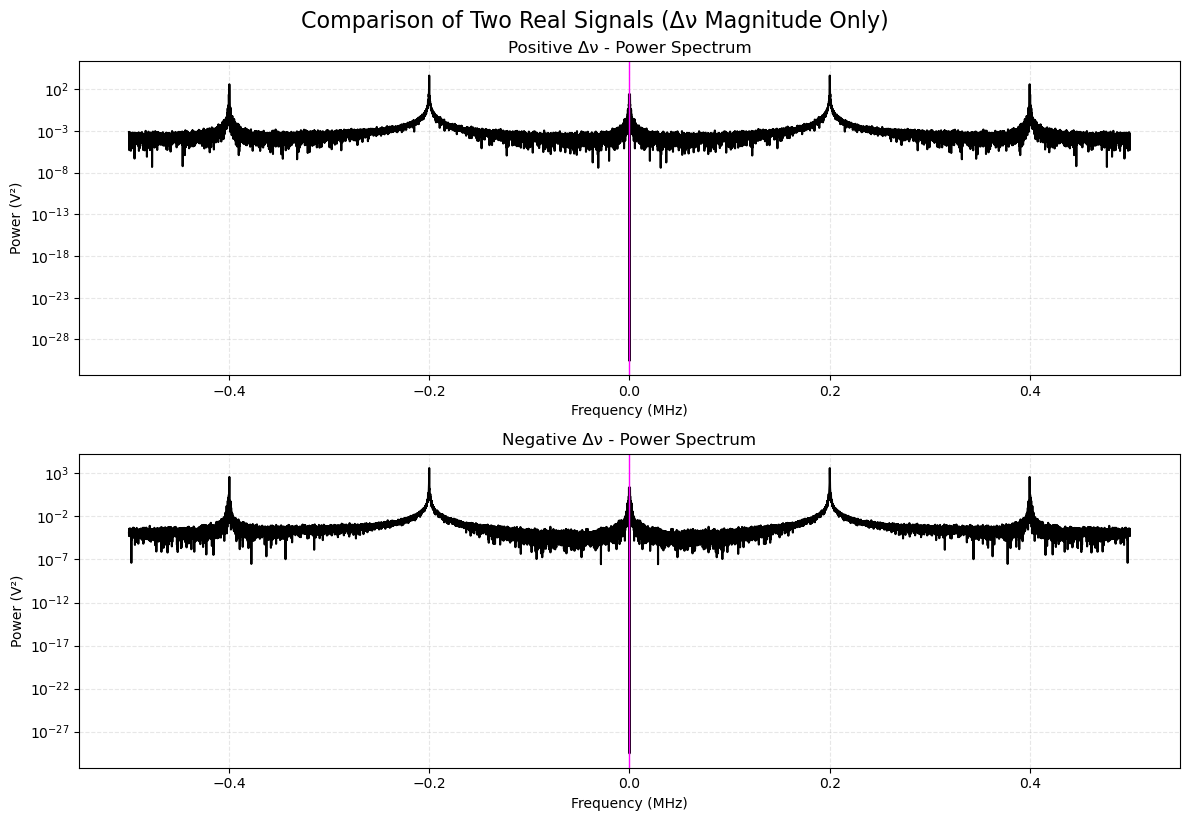

In [282]:

# -----------------------------
# NPZ files to compare
# -----------------------------
data_dir = Path("./7.3/")
npz_files = [
    "IF_from_KeysightLO10MHz_RF9p8MHz.npz",
    "IF_from_KeysightN9310A_10MHz_delayedLO_RF9p8MHz_CH2.npz"
]
labels = ["Positive Δν", "Negative Δν"]

# -----------------------------
# 2x1 subplot: Power spectra
# -----------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

for i, (fname, label) in enumerate(zip(npz_files, labels)):
    npz = np.load(data_dir / fname)
    y = npz['data'].astype(float)
    fs = float(npz['sample_rate'])
    N = len(y)
    t = np.arange(N)/fs

    # Remove DC
    y -= np.mean(y)

    # FFT
    Y = np.fft.fft(y)
    f = np.fft.fftfreq(N, 1/fs)

    # Shift zero frequency to center
    Y_shifted = np.fft.fftshift(Y)
    f_shifted = np.fft.fftshift(f)
    P_shifted = np.abs(Y_shifted)**2 / N

    # Plot
    ax = axes[i]
    ax.plot(f_shifted/1e6, P_shifted, lw=1.5, color = 'k')
    ax.set_title(f"{label} - Power Spectrum")
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Power (V²)")
    ax.set_yscale('log')
    ax.grid(True, which='both', ls='--', alpha=0.3)
    ax.axvline(0, color='magenta', lw=1)  # zero frequency

plt.tight_layout()
plt.suptitle("Comparison of Two Real Signals (Δν Magnitude Only)", fontsize=16, y=1.02)
plt.show()


# Figure 12

This figure shows the comparison between the sum and difference frequencies of a Single Sideband mixer using a 90 degree delay cable. In this case, we cannot distinguish between I/Q phases because they were not sampled into a complex array

### Unfortunately, our group was not able to sample the in phase (I) and quadrature (Q) components into a complex array. Because of this, we were unable to distinquish between the positive and negative ${\delta}{\nu}$. Typically, the asymmetry in the FFT of I +jQ would reveal the sign of ${\delta}{\nu}$. In this case, we only have a real-valued power spectrum which is symmetric and cannot be used to distinguish between the two.